In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
!pip install pmdarima

Import necessary library

In [2]:
data= pd.read_csv("Bist.csv",parse_dates=["Date"])
data.set_index("Date",inplace=True)
data.head()

,Value,Close,log,forecast
Date,,,,
1986-02-14,1.21,1.21,0.050858,NaN
1986-02-21,1.22,1.22,0.008230,NaN
1986-02-28,1.20,1.20,-0.016529,NaN
1986-03-07,1.19,1.19,-0.008368,NaN
1986-03-14,1.19,1.19,0.000000,NaN


read the csv and set index to date

In [3]:
df=data["Close"].copy().dropna()

In [4]:
df

Date
1986-02-14         1.21
1986-02-21         1.22
1986-02-28         1.20
1986-03-07         1.19
1986-03-14         1.19
                ...    
2017-11-09    110246.46
2017-11-10    108949.35
2017-11-13    108859.62
2017-11-14    110148.45
2017-11-15    107716.51
Name: Close, Length: 7596, dtype: float64

In [5]:
#check if price series is stationary
results=adfuller(df.dropna())
print(f"ADF Statistic: {results[0]}")
print(f"P-value: {results[1]}")

ADF Statistic: 0.9984620742647875
P-value: 0.9942496951131401


if the P-value lower than 0.05 is stationary but our data is bigger than 0.05 because our data is not stationary.

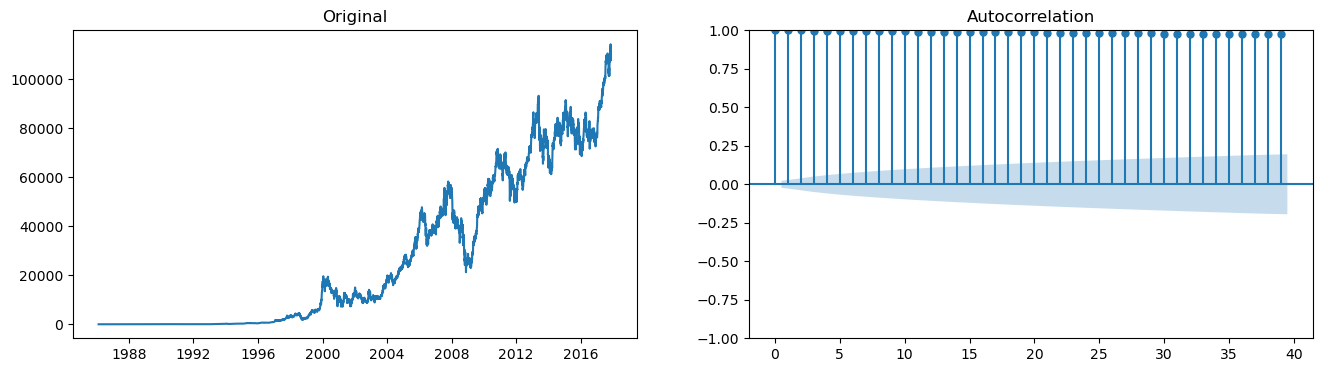

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(df)
ax1.set_title("Original")
plot_acf(df,ax=ax2)
plt.show()


also plot_acf function show us that data is not stationary. all stick outside the blue area.

In [7]:
from pmdarima.arima.utils import ndiffs

In [8]:
ndiffs(df,test="adf")

1

In [9]:
diff=df.diff().dropna()

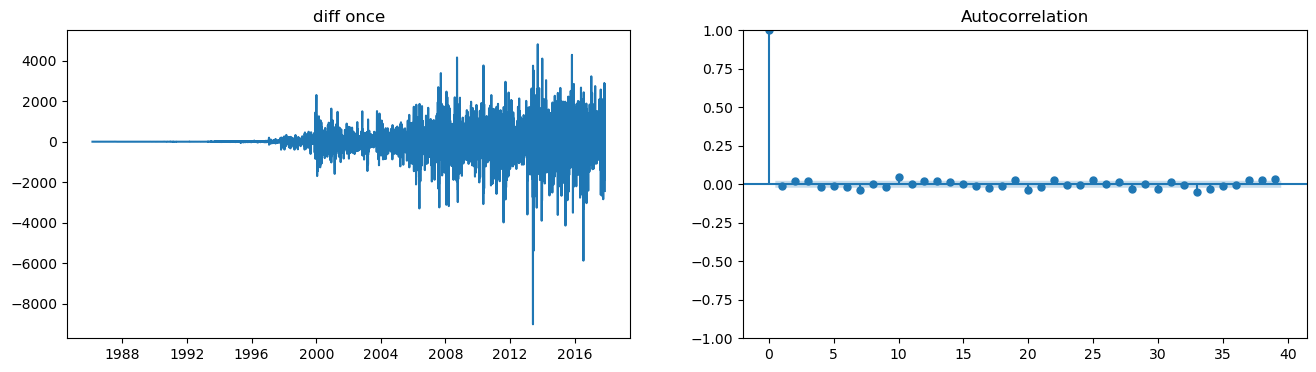

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("diff once")
plot_acf(diff,ax=ax2)
plt.show()


acf is q(MA)
we can observe that ACF lag 4 is significant as it's above the significant line.


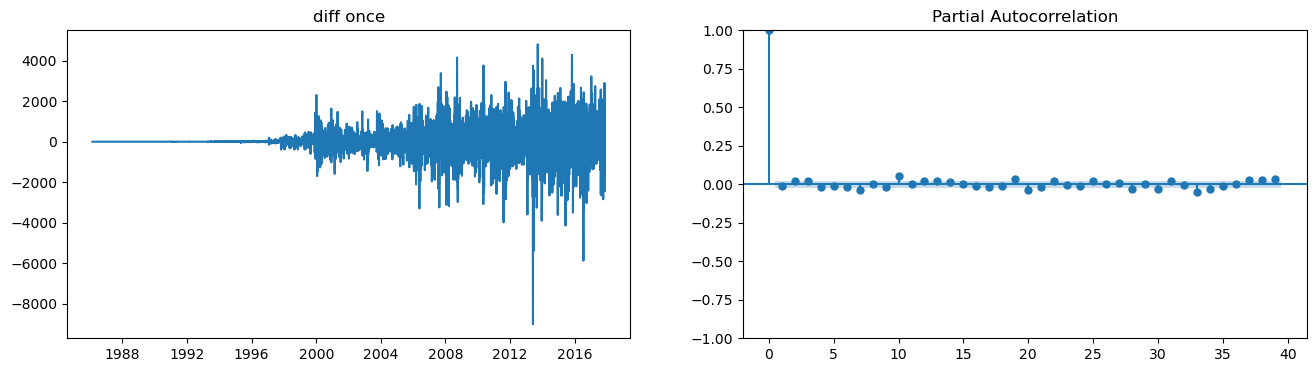

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("diff once")
plot_pacf(diff,ax=ax2)
plt.show()

pacf is p(AR)
we can observe that PACF lag 10 is significant as it's above the significant line.


In [12]:
model=ARIMA(df,order=(10,1,4))
results=model.fit()


In [13]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 7596
Model:                ARIMA(10, 1, 4)   Log Likelihood              -59676.663
Date:                Fri, 03 Mar 2023   AIC                         119383.326
Time:                        12:22:40   BIC                         119487.355
Sample:                             0   HQIC                        119419.026
                               - 7596                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3041      0.137      2.212      0.027       0.035       0.574
ar.L2          0.9239      0.136      6.797      0.000       0.657       1.190
ar.L3         -0.1707      0.092     -1.846      0.0

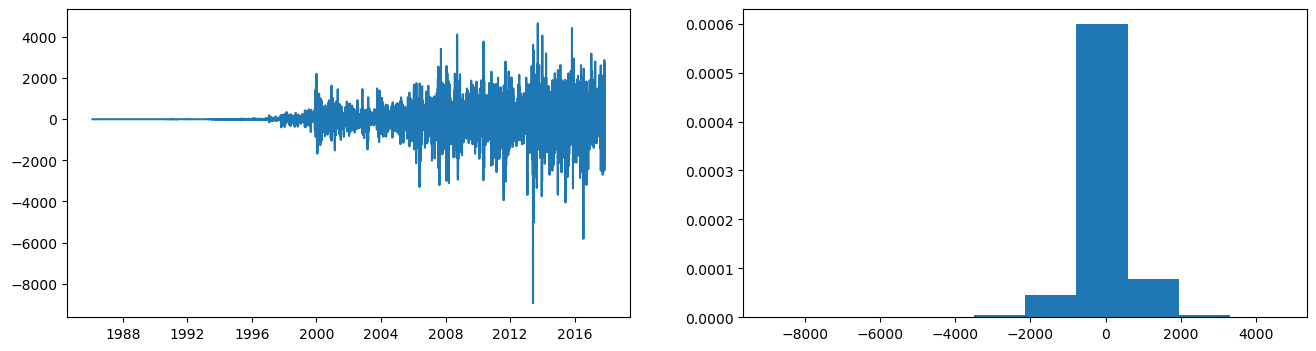

In [14]:
residuals=pd.DataFrame(results.resid)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals,density=True)

plt.show()

In [15]:
n=int(len(df)*0.8)
print(df.shape)
train=df.iloc[:n]
test=df.iloc[n:]
print(train.shape,test.shape)


(7596,)
(6076,) (1520,)


for the model I determined that train and test datas.

In [16]:
start=len(train)
end=len(train) + len(test) -1
pred=results.predict(start=start,end=end)

pred.index=df.index[start:end+1]
print(pred)

Date
2011-10-27     55416.559267
2011-10-28     56720.841166
2011-10-31     57061.336854
2011-11-01     56143.948914
2011-11-02     54926.044326
                  ...      
2017-11-09    111840.029047
2017-11-10    110141.942564
2017-11-13    108960.625212
2017-11-14    108790.299813
2017-11-15    110164.825122
Name: predicted_mean, Length: 1520, dtype: float64


we use the predict model

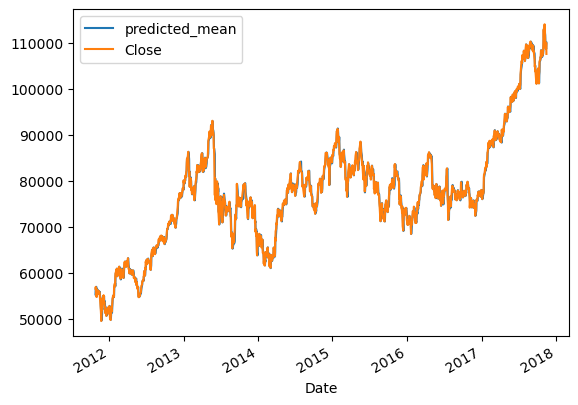

In [17]:
pred.plot(legend=True)
test.plot(legend=True)
plt.show()

In [18]:
forecast = results.get_prediction(start=1000,dynamic=True)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
print(confidence_intervals)

              lower Close    upper Close
Date                                    
1991-06-18   -1191.327490    1265.928267
1991-06-19   -1689.764956    1764.222680
1991-06-20   -2087.166935    2161.562086
1991-06-21   -2435.414043    2509.991781
1991-06-27   -2732.904053    2807.698858
...                   ...            ...
2017-11-09 -102947.369291  103022.616575
2017-11-10 -102955.180894  103030.428178
2017-11-13 -102962.991905  103038.239189
2017-11-14 -102970.802324  103046.049608
2017-11-15 -102978.612150  103053.859434

[6596 rows x 2 columns]


get_preediction=forecast of future values of the time series starting from the 1000th data point, using a dynamic approach to forecasting.
determined confidence intervals.

In [19]:
lower_limits = confidence_intervals.loc[:,'lower Close']
upper_limits = confidence_intervals.loc[:,'upper Close']


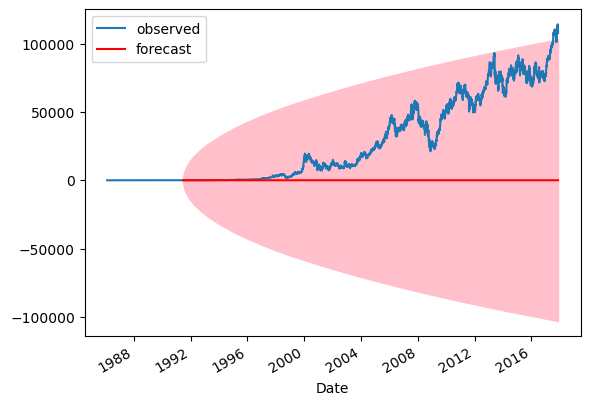

In [20]:
df.plot(label="observed")
plt.xticks(rotation=70)

#plot your mean forecast
mean_forecast.plot(color='r', label='forecast')


# shade the area between your confidence limits
plt.fill_between(mean_forecast.index, lower_limits,upper_limits, color='pink')
plt.legend()
plt.show()

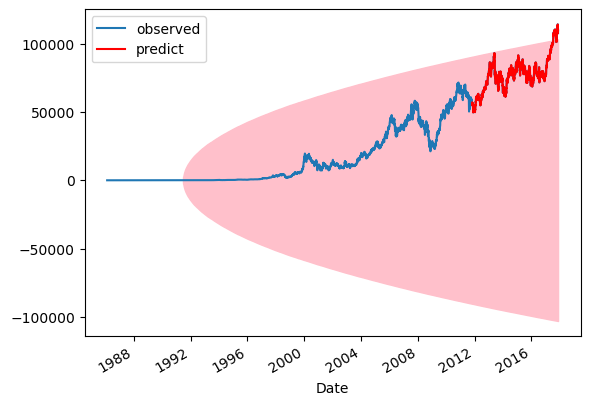

In [21]:
df.plot(label="observed")
plt.xticks(rotation=70)

#plot your mean forecast
pred.plot(color='r', label='predict')


# shade the area between your confidence limits
plt.fill_between(mean_forecast.index, lower_limits,upper_limits, color='pink')
plt.legend()
plt.show()

we plot the our prediction.

In [23]:
auto_arima= auto_arima(df,trace=True,suppres_warnings=True)
auto_arima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119424.280, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=119425.645, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=119425.675, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=119426.150, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=119427.217, Time=0.97 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 6.742 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7596
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -59710.140
Date:                Fri, 03 Mar 2023   AIC                         119424.280
Time:                        12:23:22   BIC                         119438.150
Sample:                             0   HQIC                        119429.040
                               - 7596                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.1824      7.312      1.940      0.052      -0.150      28.514
sigma2      3.946e+05   2313.783    170.549      0.000     3.9e+05    3.99e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):             60528.55
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):            2820.08   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

auto_arima model determined the best model for us

In [24]:
model1=ARIMA(df,order=(0,1,0))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 7596
Model:                ARIMA(10, 1, 4)   Log Likelihood              -59676.663
Date:                Fri, 03 Mar 2023   AIC                         119383.326
Time:                        12:23:33   BIC                         119487.355
Sample:                             0   HQIC                        119419.026
                               - 7596                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3041      0.137      2.212      0.027       0.035       0.574
ar.L2          0.9239      0.136      6.797      0.000       0.657       1.190
ar.L3         -0.1707      0.092     -1.846      0.065      -0.352       0.010
ar.L4         -0.6669      0.109     -6.135      0.000      -0.880      -0.454
ar.L5         -0.0283      0.012     -2.340      0.019      -0.052      -0.005
ar.L6          0.0170      0.012      1.470      0.141      -0.006       0.040
ar.L7          0.0027      0.010      0.259      0.796      -0.018       0.023
ar.L8          0.0301      0.010      2.926      0.003       0.010       0.050
ar.L9         -0.0107      0.012     -0.858      0.391      -0.035       0.014
ar.L10         0.0093      0.010      0.912      0.362      -0.011       0.029
ma.L1         -0.3163      0.138     -2.299      0.021      -0.586      -0.047
ma.L2         -0.9011      0.137     -6.567      0.000      -1.170      -0.632
ma.L3          0.1992      0.090      2.214      0.027       0.023       0.375
ma.L4          0.6269      0.110      5.682      0.000       0.411       0.843
sigma2       3.93e+05   2500.417    157.156      0.000    3.88e+05    3.98e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             58168.94
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):            5684.05   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
start1=len(train)
end1=len(train) + len(test) -1
pred1=result.predict(start=start1,end=end1)

pred1.index=df.index[start1:end1 +1]
print(pred1)

Date
2011-10-27     55416.559267
2011-10-28     56720.841166
2011-10-31     57061.336854
2011-11-01     56143.948914
2011-11-02     54926.044326
                  ...      
2017-11-09    111840.029047
2017-11-10    110141.942564
2017-11-13    108960.625212
2017-11-14    108790.299813
2017-11-15    110164.825122
Name: predicted_mean, Length: 1520, dtype: float64


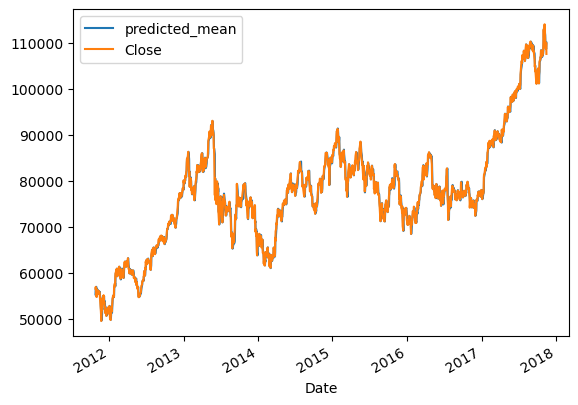

In [26]:
pred1.plot(legend=True)
test.plot(legend=True)
plt.show()

In [27]:
forecast1 = result.get_prediction(start=1000,dynamic=True)
mean_forecast1 = forecast.predicted_mean
confidence_intervals1 = forecast.conf_int()
print(confidence_intervals)

              lower Close    upper Close
Date                                    
1991-06-18   -1191.327490    1265.928267
1991-06-19   -1689.764956    1764.222680
1991-06-20   -2087.166935    2161.562086
1991-06-21   -2435.414043    2509.991781
1991-06-27   -2732.904053    2807.698858
...                   ...            ...
2017-11-09 -102947.369291  103022.616575
2017-11-10 -102955.180894  103030.428178
2017-11-13 -102962.991905  103038.239189
2017-11-14 -102970.802324  103046.049608
2017-11-15 -102978.612150  103053.859434

[6596 rows x 2 columns]


In [28]:
lower_limits1 = confidence_intervals1.loc[:,'lower Close']
upper_limits1 = confidence_intervals1.loc[:,'upper Close']


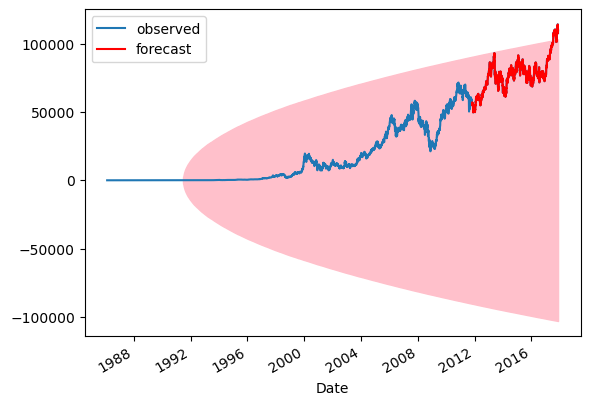

In [29]:
df.plot(label="observed")
plt.xticks(rotation=70)

#plot your mean forecast
pred1.plot(color='r', label='forecast')


# shade the area between your confidence limits
plt.fill_between(mean_forecast1.index, lower_limits1,upper_limits1, color='pink')
plt.legend()
plt.show()